# LABORATORY SESSION - WEEK 12

## Understanding The Articles 

- What types of trolls are there in the database?
    - normal american citizens (comments on real time events)
    - local news outlets (violence)
    - local political party (republican)
- How to tell them apart?
    - community detection algorithm
- What do trolls do?
    - rigth wing (positive tweets)
    - left wing (negative tweets)
    - black lives matter community
- What hashtags they used?
    - ashtags

In [103]:
# import 
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from datetime import datetime
import random
import matplotlib.patches as mpatches
import seaborn as sns 
from networkx.algorithms.community import girvan_newman

### Problem 1 

Import tweeter data. Draw networks illustrating the relationships inside them. 

### Solution 

In [32]:
# Data file paths
tweets_dir = "data/tweets.csv"
users_dir = "data/users.csv"

# Load datasets using pandas
tweets_df = pd.read_csv(tweets_dir)
users_df = pd.read_csv(users_dir)

# Compute and display the number of rows and columns for each dataset
print("\nTweets Dataset Dimensions:")
print(f"Rows: {tweets_df.shape[0]}, Columns: {tweets_df.shape[1]}")

print("\nUsers Dataset Dimensions:")
print(f"Rows: {users_df.shape[0]}, Columns: {users_df.shape[1]}")

# Display column names for clarity
print("\nTweets Dataset Columns:")
print(tweets_df.columns)

print("\nUsers Dataset Columns:")
print(users_df.columns)

# Display attribute by attribute for an example row from Tweets dataset
print("\nExample Row from Tweets Dataset (Attribute by Attribute):")
example_tweet = tweets_df.iloc[0]
for column, value in example_tweet.items():
    print(f"{column}: {value}")

# Display attribute by attribute for an example row from Users dataset
print("\nExample Row from Users Dataset (Attribute by Attribute):")
example_user = users_df.iloc[0]
for column, value in example_user.items():
    print(f"{column}: {value}")



Tweets Dataset Dimensions:
Rows: 203451, Columns: 16

Users Dataset Dimensions:
Rows: 453, Columns: 14

Tweets Dataset Columns:
Index(['user_id', 'user_key', 'created_at', 'created_str', 'retweet_count',
       'retweeted', 'favorite_count', 'text', 'tweet_id', 'source', 'hashtags',
       'expanded_urls', 'posted', 'mentions', 'retweeted_status_id',
       'in_reply_to_status_id'],
      dtype='object')

Users Dataset Columns:
Index(['id', 'location', 'name', 'followers_count', 'statuses_count',
       'time_zone', 'verified', 'lang', 'screen_name', 'description',
       'created_at', 'favourites_count', 'friends_count', 'listed_count'],
      dtype='object')

Example Row from Tweets Dataset (Attribute by Attribute):
user_id: 2532611755.0
user_key: kathiemrr
created_at: 1488207240000.0
created_str: 2017-02-27 14:54:00
retweet_count: nan
retweeted: nan
favorite_count: nan
text: #ThingsDoneByMistake kissing auntie in the lips
tweet_id: 8.362278918976512e+17
source: nan
hashtags: ["Thin

In [74]:
# Check if the number of tweets per user in 'tweets_df' corresponds with 'statuses_count' in 'users_df'

# Get the number of tweets per user
tweets_per_user = tweets_df.groupby('user_id').size()

# Check if these numbers match the statuses_count in the users dataset
users_df['tweets_in_data'] = users_df['id'].map(tweets_per_user)
users_df['tweets_match'] = users_df['statuses_count'] == users_df['tweets_in_data']

# Display users where there is a mismatch between the expected and actual tweet count
mismatched_users = users_df[users_df['tweets_match'] == False]

print("\nMismatched Users (Status Count vs. Tweets Count):")
print(mismatched_users[['id', 'statuses_count', 'tweets_in_data', 'tweets_match']])



Mismatched Users (Status Count vs. Tweets Count):
              id  statuses_count  tweets_in_data  tweets_match
0    100345056.0         31858.0            68.0         False
1    247165706.0          6742.0            56.0         False
2    249538861.0           843.0            23.0         False
3    449689677.0         10877.0             7.0         False
4    471868887.0         18401.0             5.0         False
..           ...             ...             ...           ...
448          NaN             NaN             NaN         False
449          NaN             NaN             NaN         False
450          NaN             NaN             NaN         False
451          NaN             NaN             NaN         False
452          NaN             NaN             NaN         False

[453 rows x 4 columns]


In [75]:
# Group tweets by user and calculate the total number of tweets and activity metrics
user_activity = tweets_df.groupby('user_id').agg(
    total_tweets=('user_id', 'size'),
    total_retweets=('retweet_count', 'sum'),
    total_likes=('favorite_count', 'sum'),
    mentions=('mentions', lambda x: x.explode().value_counts().to_dict())
)

# Add activity data from users dataset (e.g., statuses_count)
user_activity = user_activity.merge(users_df[['id', 'statuses_count']], left_index=True, right_on='id')

# Display the result
print(user_activity.head())


     total_tweets  total_retweets  total_likes  \
316             1             0.0          0.0   
325             3             0.0          0.0   
0              68            17.0         35.0   
1              56             1.0          1.0   
2              23             1.0          0.0   

                                              mentions           id  \
316                           {'["thebaxterbean"]': 1}   38875764.0   
325                                          {'[]': 3}   87588938.0   
0    {'["realdonaldtrump"]': 34, '[]': 9, '["realdo...  100345056.0   
1    {'[]': 24, '["hillaryclinton"]': 3, '["goldeng...  247165706.0   
2    {'[]': 7, '["benshapiro"]': 2, '["marycmccorma...  249538861.0   

     statuses_count  
316           219.0  
325         61735.0  
0           31858.0  
1            6742.0  
2             843.0  


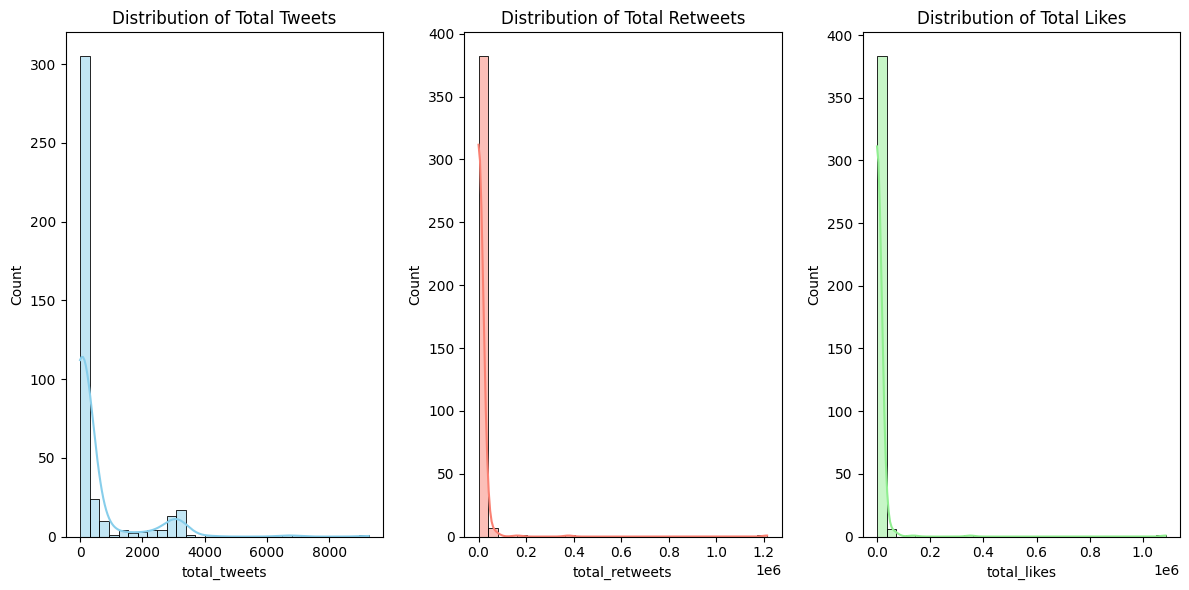

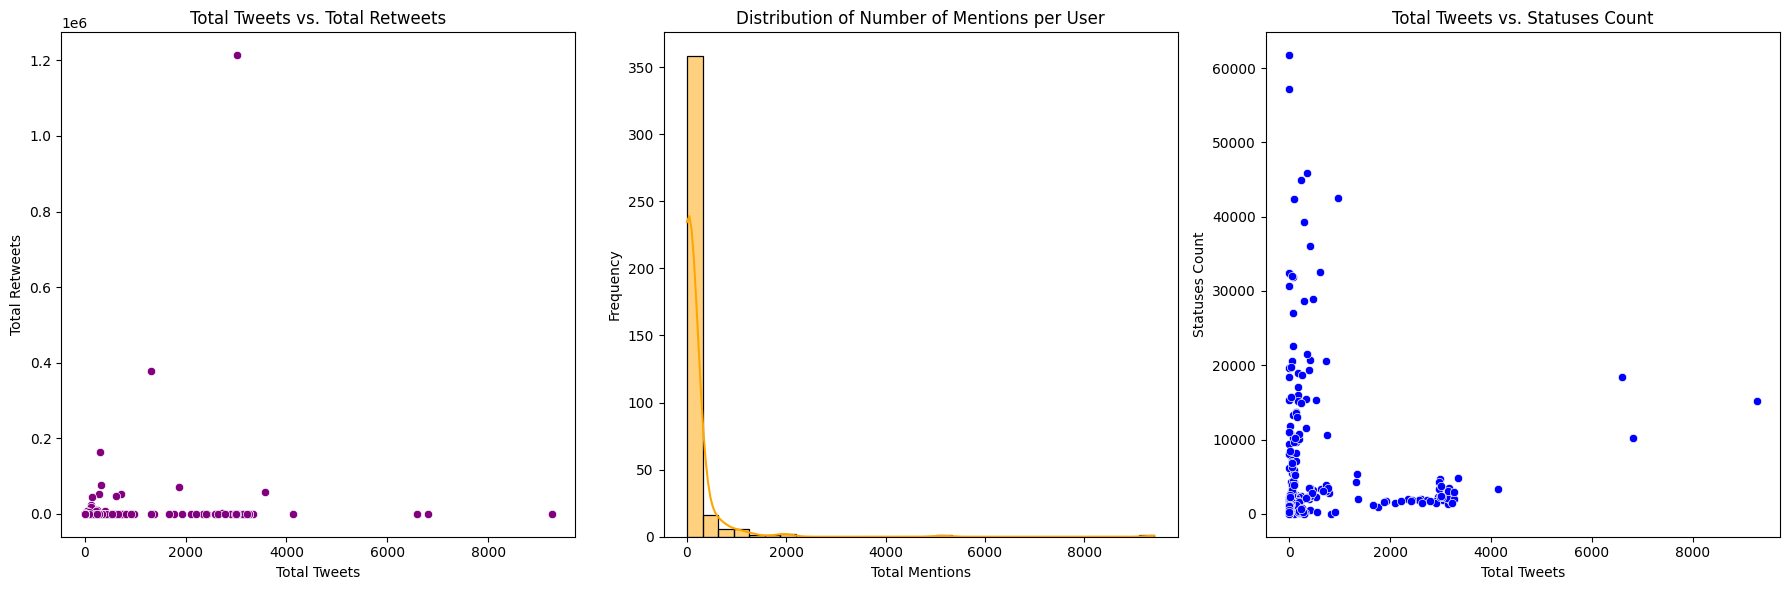

In [79]:
# Merging the datasets to connect tweets with user information
user_tweet_stats = pd.merge(
    tweets_df.groupby('user_id').agg(
        total_tweets=('tweet_id', 'count'),
        total_retweets=('retweet_count', 'sum'),
        total_likes=('favorite_count', 'sum'),
        total_mentions=('mentions', lambda x: sum([len(eval(m)) for m in x if m != '[]']))  # Count mentions
    ).reset_index(),
    users_df[['id', 'statuses_count', 'screen_name']],
    left_on='user_id', right_on='id', how='left'
)

# 1. Distribution of total tweets, retweets, and likes for users
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.histplot(user_tweet_stats['total_tweets'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of Total Tweets')

plt.subplot(1, 3, 2)
sns.histplot(user_tweet_stats['total_retweets'], kde=True, color='salmon', bins=30)
plt.title('Distribution of Total Retweets')

plt.subplot(1, 3, 3)
sns.histplot(user_tweet_stats['total_likes'], kde=True, color='lightgreen', bins=30)
plt.title('Distribution of Total Likes')

plt.tight_layout()
plt.show()

# Create subplots to display all three plots in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 2. Total Tweets vs. Total Retweets
sns.scatterplot(x='total_tweets', y='total_retweets', data=user_tweet_stats, color='purple', ax=axes[0])
axes[0].set_title('Total Tweets vs. Total Retweets')
axes[0].set_xlabel('Total Tweets')
axes[0].set_ylabel('Total Retweets')

# 3. Number of Mentions per User
sns.histplot(user_tweet_stats['total_mentions'], kde=True, color='orange', bins=30, ax=axes[1])
axes[1].set_title('Distribution of Number of Mentions per User')
axes[1].set_xlabel('Total Mentions')
axes[1].set_ylabel('Frequency')

# 4. Comparison of Activity (Total Tweets vs Status Count)
sns.scatterplot(x='total_tweets', y='statuses_count', data=user_tweet_stats, color='blue', ax=axes[2])
axes[2].set_title('Total Tweets vs. Statuses Count')
axes[2].set_xlabel('Total Tweets')
axes[2].set_ylabel('Statuses Count')

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plots
plt.show()


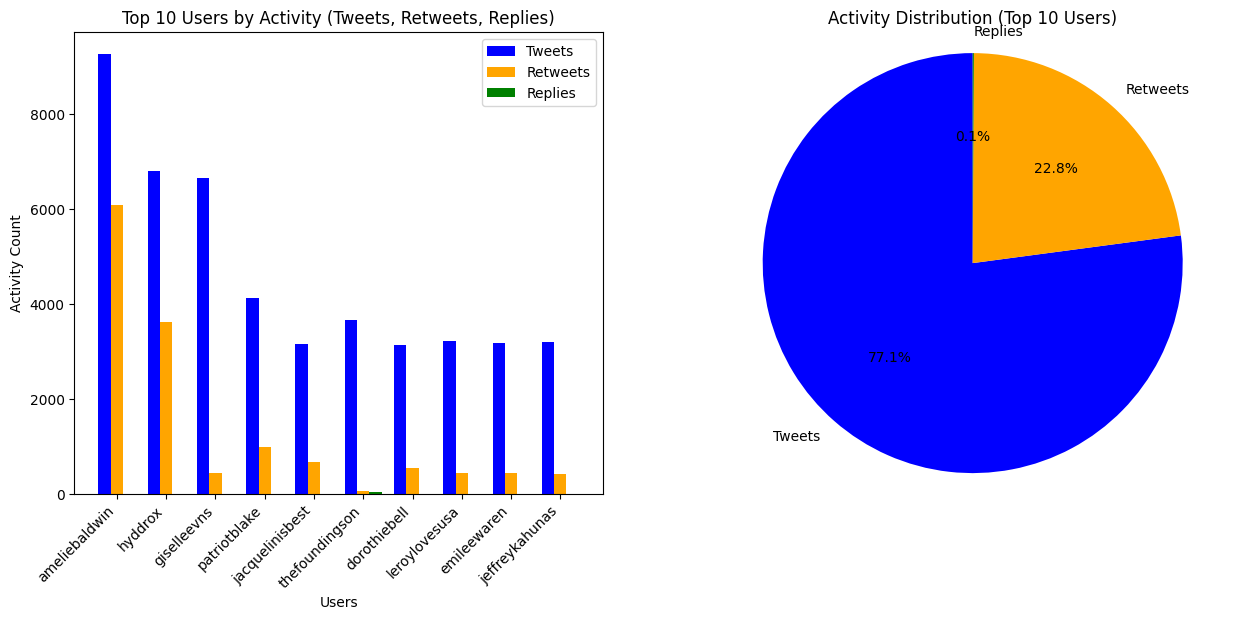

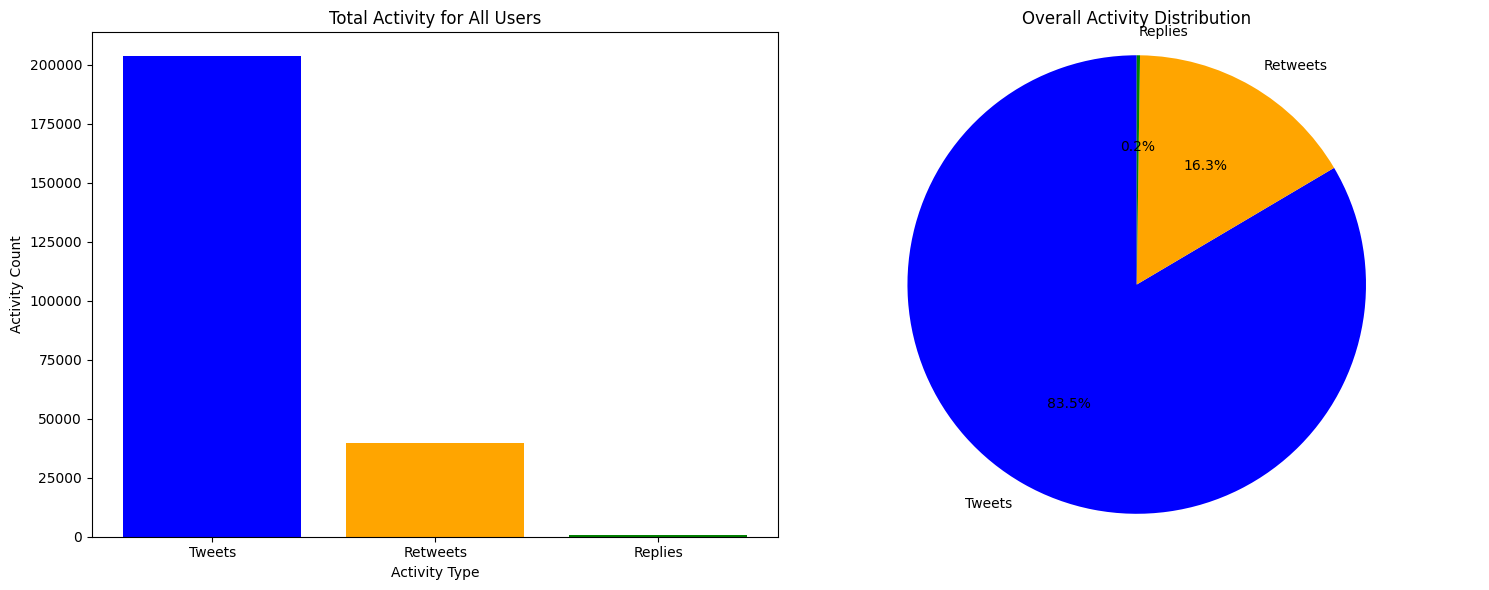

In [80]:
# Group data by user and compute activity metrics (Tweets, Retweets, and Replies)
def compute_user_activity(tweets_df):
    # Initialize a dictionary to store activity
    user_activity = tweets_df.groupby('user_key').agg(
        tweets=('user_key', 'size'),  # Count total tweets
        retweets=('retweeted_status_id', lambda x: x.notna().sum()),  # Count retweets
        replies=('in_reply_to_status_id', lambda x: x.notna().sum())  # Count replies
    ).reset_index()
    return user_activity

# Load data
tweets_dir = "data/tweets.csv"
tweets_df = pd.read_csv(tweets_dir)

# Compute activity
user_activity = compute_user_activity(tweets_df)

# Sort by total activity for plotting (Top 10 Users)
user_activity['total_activity'] = user_activity['tweets'] + user_activity['retweets'] + user_activity['replies']
top_users = user_activity.sort_values(by='total_activity', ascending=False).head(10)

# Analysis on the entire user base (all users)
total_tweets = user_activity['tweets'].sum()
total_retweets = user_activity['retweets'].sum()
total_replies = user_activity['replies'].sum()

# Plot activity
def plot_user_activity(top_users, user_activity):
    # Prepare for plotting
    x = np.arange(len(top_users))
    width = 0.25  # Bar width
    
    # Create the bar chart for tweets, retweets, and replies (Top 10 users)
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Bar chart for Tweets, Retweets, and Replies (Top 10 Users)
    ax[0].bar(x - width, top_users['tweets'], width, label='Tweets', color='blue')
    ax[0].bar(x, top_users['retweets'], width, label='Retweets', color='orange')
    ax[0].bar(x + width, top_users['replies'], width, label='Replies', color='green')

    ax[0].set_xticks(x)
    ax[0].set_xticklabels(top_users['user_key'], rotation=45, ha='right')
    ax[0].set_xlabel('Users')
    ax[0].set_ylabel('Activity Count')
    ax[0].set_title('Top 10 Users by Activity (Tweets, Retweets, Replies)')
    ax[0].legend()

    # Pie chart for distribution of tweet, retweet, and reply activities for top users
    activities = [top_users['tweets'].sum(), top_users['retweets'].sum(), top_users['replies'].sum()]
    labels = ['Tweets', 'Retweets', 'Replies']
    colors = ['blue', 'orange', 'green']
    
    ax[1].pie(activities, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax[1].set_title('Activity Distribution (Top 10 Users)')

    # Plotting total activity for all users (bar chart and pie chart)
    fig2, ax2 = plt.subplots(1, 2, figsize=(15, 6))

    # Bar chart for total tweets, retweets, and replies (All Users)
    ax2[0].bar(['Tweets', 'Retweets', 'Replies'], [total_tweets, total_retweets, total_replies], color=['blue', 'orange', 'green'])
    ax2[0].set_xlabel('Activity Type')
    ax2[0].set_ylabel('Activity Count')
    ax2[0].set_title('Total Activity for All Users')

    # Pie chart for the entire user base distribution
    total_activities = [total_tweets, total_retweets, total_replies]
    labels = ['Tweets', 'Retweets', 'Replies']
    colors = ['blue', 'orange', 'green']
    
    ax2[1].pie(total_activities, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax2[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax2[1].set_title('Overall Activity Distribution')

    plt.tight_layout()
    plt.show()

# Plot the activity for the top users and the entire user base
plot_user_activity(top_users, user_activity)


In [81]:
import pandas as pd
import networkx as nx

def create_twitter_network(users_df: pd.DataFrame, tweets_df: pd.DataFrame) -> nx.Graph:
    """
    Creates an undirected graph representing a Twitter network based on user interactions.
    
    Parameters:
        users_df (pd.DataFrame): DataFrame with user data containing ['id', 'name', 'location']
        tweets_df (pd.DataFrame): DataFrame with tweet data containing 
                                  ['user_id', 'mentions', 'retweeted_status_id', 'tweet_id', 'text']
    
    Returns:
        nx.Graph: Undirected graph where nodes are users and edges represent interactions.
    """
    # Initialize graph
    G = nx.Graph()

    def add_users_from_dataframe():
        """Add users from users_df as nodes with attributes."""
        for _, user in users_df.iterrows():
            user_id = user['id']
            if pd.notnull(user_id):
                G.add_node(
                    user_id,
                    name=str(user.get('name', '')),
                    location=str(user.get('location', '')),
                    type='user'
                )

    def add_users_from_tweets():
        """Add users found in tweets but not in users_df."""
        tweet_users = pd.unique(tweets_df['user_id'].dropna())
        for user_id in tweet_users:
            if pd.notnull(user_id) and not G.has_node(user_id):
                G.add_node(
                    user_id,
                    name=f"User_{user_id}",
                    location="Unknown",
                    type='user'
                )

    def add_interaction_edges():
        """Add edges based on mentions, retweets, and replies."""
        for _, tweet in tweets_df.iterrows():
            source_id = tweet['user_id']
            if pd.isnull(source_id):
                continue
            
            # Handle mentions
            mentions = tweet.get('mentions', [])
            if isinstance(mentions, list):
                for target_id in mentions:
                    if pd.notnull(target_id) and source_id != target_id:
                        # Add or update edge for mention
                        weight = 1  # Default weight for mention
                        if G.has_edge(source_id, target_id):
                            G[source_id][target_id]['weight'] += weight
                            G[source_id][target_id]['mentions'].append(tweet['tweet_id'])
                        else:
                            G.add_edge(
                                source_id,
                                target_id,
                                weight=weight,
                                type='mention',
                                mentions=[tweet['tweet_id']]
                            )

            # Handle retweets
            retweeted_status_id = tweet.get('retweeted_status_id')
            if pd.notnull(retweeted_status_id):
                # Find the user who posted the original tweet
                original_tweet = tweets_df[tweets_df['tweet_id'] == retweeted_status_id]
                if not original_tweet.empty:
                    target_id = original_tweet.iloc[0]['user_id']
                    if pd.notnull(target_id) and source_id != target_id:
                        # Add or update edge for retweet
                        weight = 1  # Default weight for retweet
                        if G.has_edge(source_id, target_id):
                            G[source_id][target_id]['weight'] += weight
                            G[source_id][target_id]['retweets'].append(tweet['tweet_id'])
                        else:
                            G.add_edge(
                                source_id,
                                target_id,
                                weight=weight,
                                type='retweet',
                                retweets=[tweet['tweet_id']]
                            )

            # Handle replies (if applicable)
            # Assuming replies are identified by the presence of a 'reply_to_tweet_id' field
            reply_to_tweet_id = tweet.get('reply_to_tweet_id')
            if pd.notnull(reply_to_tweet_id):
                # Find the user who posted the original tweet being replied to
                original_reply_tweet = tweets_df[tweets_df['tweet_id'] == reply_to_tweet_id]
                if not original_reply_tweet.empty:
                    target_id = original_reply_tweet.iloc[0]['user_id']
                    if pd.notnull(target_id) and source_id != target_id:
                        # Add or update edge for reply
                        weight = 1  # Default weight for reply
                        if G.has_edge(source_id, target_id):
                            G[source_id][target_id]['weight'] += weight
                            G[source_id][target_id]['replies'].append(tweet['tweet_id'])
                        else:
                            G.add_edge(
                                source_id,
                                target_id,
                                weight=weight,
                                type='reply',
                                replies=[tweet['tweet_id']]
                            )

    # Build network
    add_users_from_dataframe()
    add_users_from_tweets()
    add_interaction_edges()

    # Remove isolated nodes (users with no interactions)
    G.remove_nodes_from(list(nx.isolates(G)))

    return G

def get_network_stats(G: nx.Graph) -> dict:
    """
    Calculate basic network statistics.
    
    Parameters:
        G (nx.Graph): NetworkX graph object
    
    Returns:
        dict: Dictionary containing network statistics
    """
    return {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
        'num_components': nx.number_connected_components(G),
        'largest_component_size': len(max(nx.connected_components(G), key=len)),
        'avg_clustering': nx.average_clustering(G),
        'mention_edges': sum(1 for _, _, d in G.edges(data=True) if d.get('type') == 'mention'),
        'retweet_edges': sum(1 for _, _, d in G.edges(data=True) if d.get('type') == 'retweet'),
        'reply_edges': sum(1 for _, _, d in G.edges(data=True) if d.get('type') == 'reply')
    }

# Example usage
tweets_dir = "data/tweets.csv"
users_dir = "data/users.csv"
tweets_df = pd.read_csv(tweets_dir)
users_df = pd.read_csv(users_dir)

# Create network
G = create_twitter_network(users_df, tweets_df)

# Get network statistics
stats = get_network_stats(G)
print("\nNetwork Statistics:")
for key, value in stats.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")


Network Statistics:
num_nodes: 136
num_edges: 540
density: 0.06
avg_degree: 7.94
num_components: 4
largest_component_size: 129
avg_clustering: 0.36
mention_edges: 0
retweet_edges: 540
reply_edges: 0


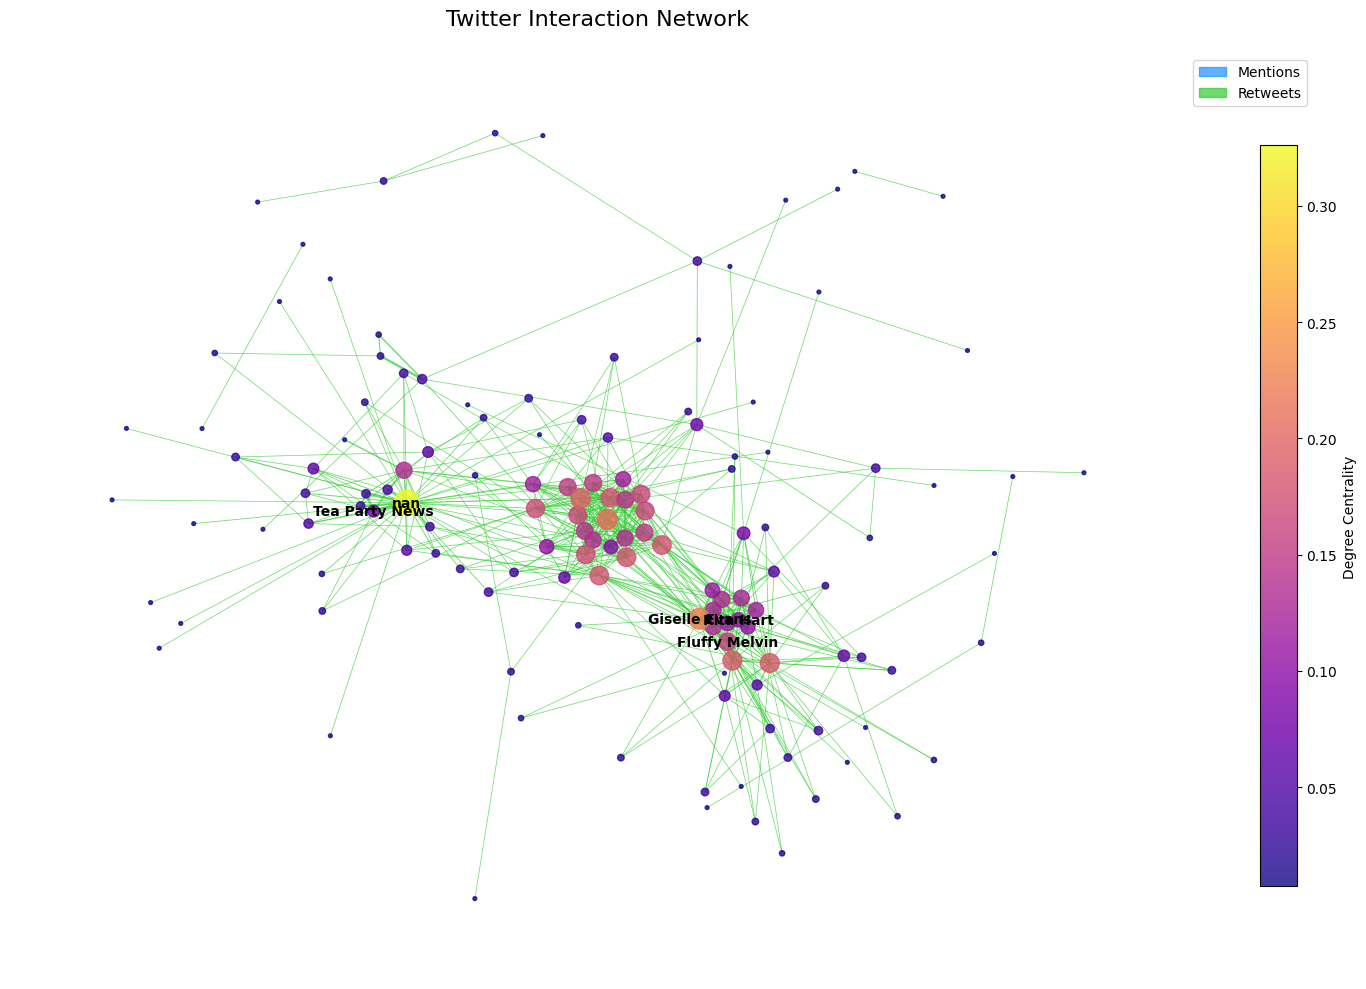

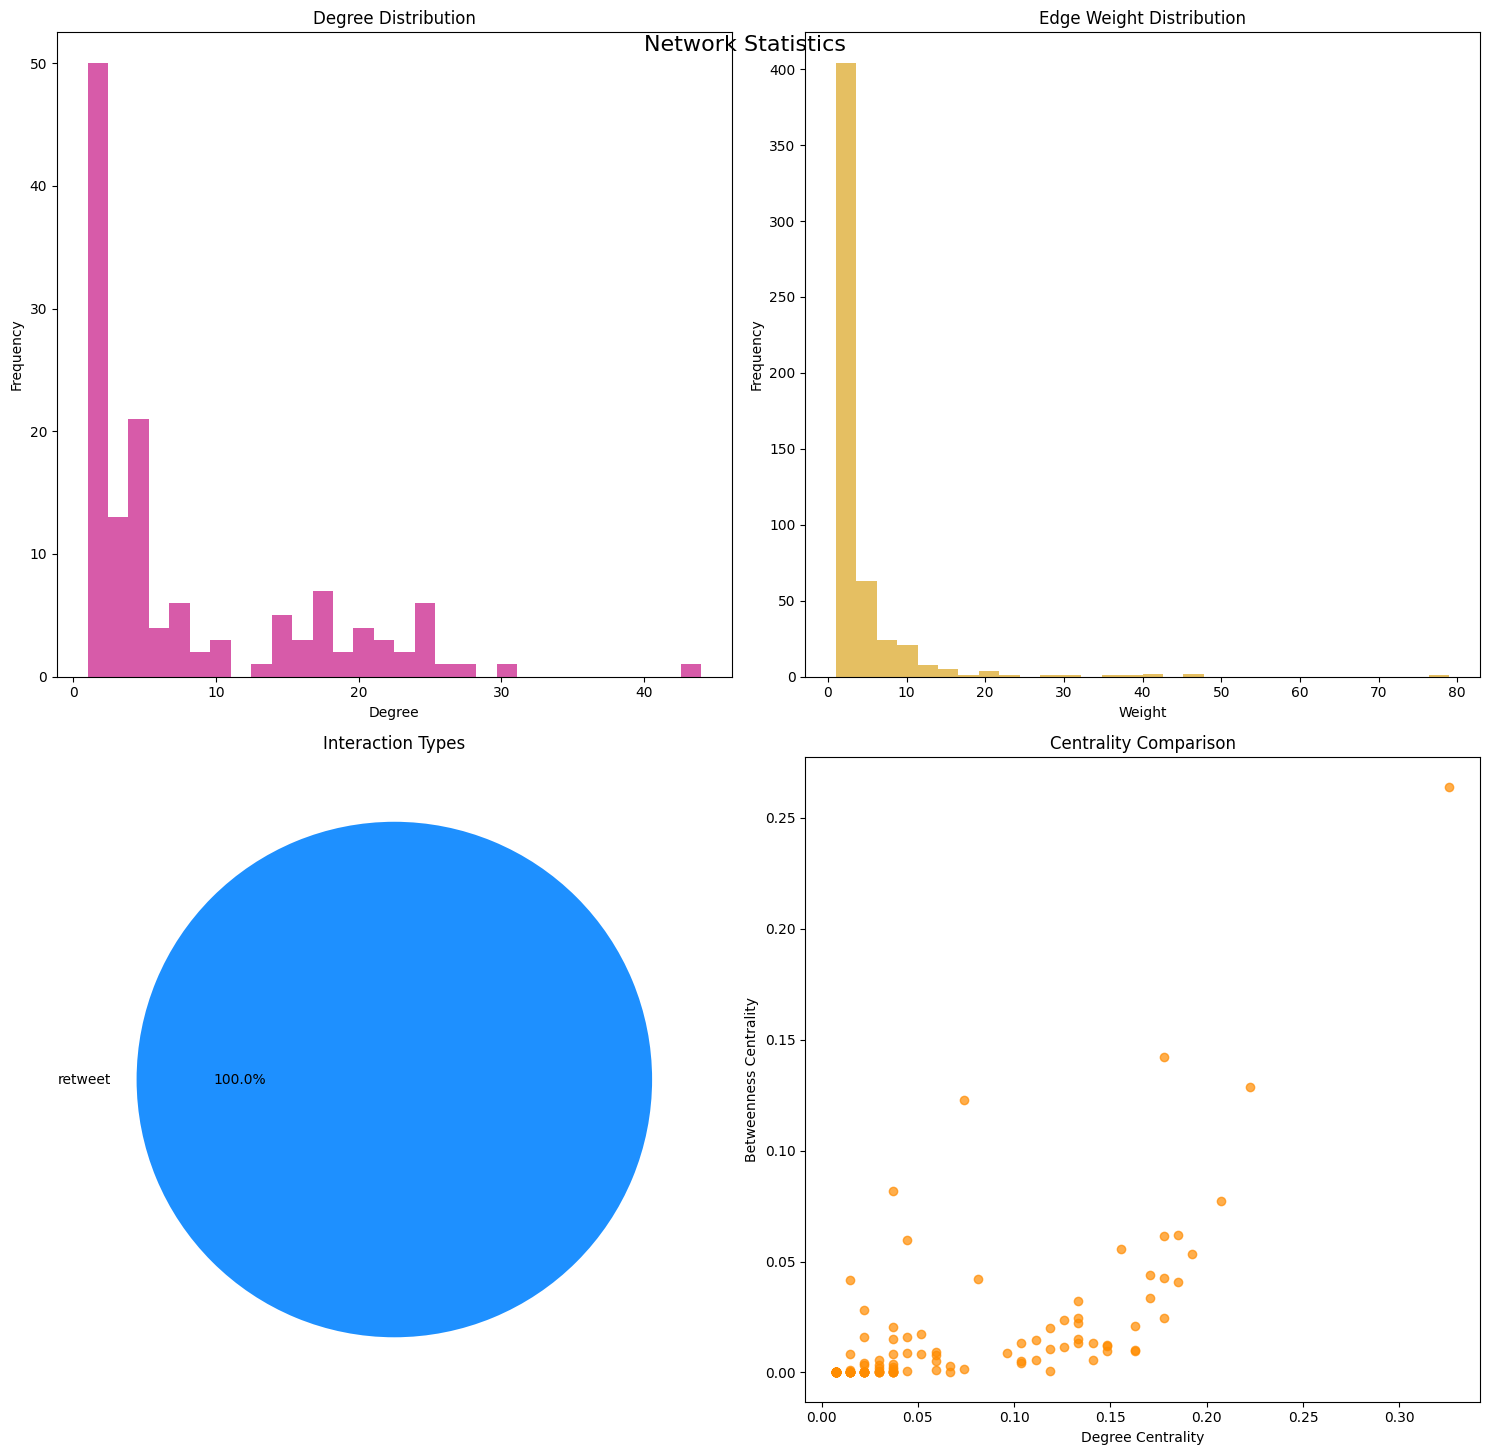

In [86]:
def visualize_network(G, title="Twitter Interaction Network", figsize=(15, 10)):
    """
    Creates an enhanced visualization of the Twitter interaction network.
    
    Parameters:
        G (nx.Graph): NetworkX graph of Twitter interactions
        title (str): Title for the visualization
        figsize (tuple): Figure size in inches
    """
    # Create figure
    plt.figure(figsize=figsize)
    plt.axis('off')
    
    # Calculate node sizes based on degree centrality
    degree_cent = nx.degree_centrality(G)
    node_sizes = [1000 * degree_cent[node] for node in G.nodes()]
    
    # Calculate edge weights for thickness
    edge_weights = [G[u][v].get('weight', 1) for u, v in G.edges()]
    max_weight = max(edge_weights)
    normalized_weights = [0.5 + 2.0 * (w / max_weight) for w in edge_weights]
    
    # Set up layout
    pos = nx.spring_layout(G, k=0.4, seed=42)
    
    # Separate edges by type
    mention_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'mention']
    retweet_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'retweet']
    
    # Draw edges
    nx.draw_networkx_edges(G, pos,
                          edgelist=mention_edges,
                          edge_color='dodgerblue',  # changed for clarity
                          alpha=0.7,
                          width=[normalized_weights[i] for i, (u, v) in enumerate(G.edges()) 
                                if (u, v) in mention_edges or (v, u) in mention_edges])
    
    nx.draw_networkx_edges(G, pos,
                          edgelist=retweet_edges,
                          edge_color='limegreen',  # changed for clarity
                          alpha=0.7,
                          width=[normalized_weights[i] for i, (u, v) in enumerate(G.edges())
                                if (u, v) in retweet_edges or (v, u) in retweet_edges])
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos,
                                 node_size=node_sizes,
                                 node_color=list(degree_cent.values()),
                                 cmap=plt.cm.plasma,  # changed for better contrast
                                 alpha=0.8)
    
    # Add colorbar for node centrality
    plt.colorbar(nodes, label='Degree Centrality', shrink=0.8)
    
    # Add labels for top nodes
    node_importance = {}
    for node in G.nodes():
        degree = G.degree(node, weight='weight')
        node_importance[node] = degree
    
    top_nodes = sorted(node_importance.items(), key=lambda x: x[1], reverse=True)[:5]
    labels = {node: G.nodes[node].get('name', f'User_{node}') 
             for node, _ in top_nodes}
    
    nx.draw_networkx_labels(G, pos,
                          labels=labels,
                          font_size=10,
                          font_weight='bold',
                          font_color='black')
    
    # Add legend
    legend_elements = [
        mpatches.Patch(color='dodgerblue', alpha=0.7, label='Mentions'),
        mpatches.Patch(color='limegreen', alpha=0.7, label='Retweets'),
    ]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    
    # Add title and adjust layout
    plt.title(title, pad=20, size=16)
    plt.tight_layout()
    
    return plt

def plot_network_statistics(G):
    """
    Creates a subplot of various network statistics visualizations.
    
    Parameters:
        G (nx.Graph): NetworkX graph of Twitter interactions
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('Network Statistics', fontsize=16, y=0.95)
    
    # Degree distribution
    degrees = [d for n, d in G.degree()]
    axes[0, 0].hist(degrees, bins=30, alpha=0.7, color='mediumvioletred')  # changed for better distinction
    axes[0, 0].set_title('Degree Distribution')
    axes[0, 0].set_xlabel('Degree')
    axes[0, 0].set_ylabel('Frequency')
    
    # Edge weight distribution
    weights = [d['weight'] for u, v, d in G.edges(data=True)]
    axes[0, 1].hist(weights, bins=30, alpha=0.7, color='goldenrod')  # changed for better distinction
    axes[0, 1].set_title('Edge Weight Distribution')
    axes[0, 1].set_xlabel('Weight')
    axes[0, 1].set_ylabel('Frequency')
    
    # Interaction types
    interaction_types = [d['type'] for u, v, d in G.edges(data=True)]
    type_counts = pd.Series(interaction_types).value_counts()
    axes[1, 0].pie(type_counts, labels=type_counts.index, autopct='%1.1f%%',
                   colors=['dodgerblue', 'limegreen'])  # consistent with edge colors
    axes[1, 0].set_title('Interaction Types')
    
    # Node centrality comparison
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    axes[1, 1].scatter(list(degree_cent.values()), 
                      list(betweenness_cent.values()),
                      alpha=0.7, color='darkorange')  # changed for clarity
    axes[1, 1].set_xlabel('Degree Centrality')
    axes[1, 1].set_ylabel('Betweenness Centrality')
    axes[1, 1].set_title('Centrality Comparison')
    
    plt.tight_layout()
    return plt

# Basic network visualization
visualize_network(G)
plt.show()

# Detailed statistics visualization
plot_network_statistics(G)
plt.show()


In [117]:
def filter_clusters(communities, min_size=3):
    """
    Filters out small (noisy) clusters.
    
    Parameters:
        communities (list): List of sets, where each set contains nodes in a cluster.
        min_size (int): Minimum size of clusters to retain.
    
    Returns:
        list: Filtered list of clusters.
    """
    return [community for community in communities if len(community) >= min_size]


def visualize_network_clusters(G, communities, title="Twitter Interaction Network with Clusters", figsize=(15, 10)):
    """
    Visualizes a network while highlighting clusters and adds a legend for cluster colors.
    
    Parameters:
        G (nx.Graph): NetworkX graph
        communities (list): List of sets, where each set contains nodes in a cluster
        title (str): Title for the visualization
        figsize (tuple): Figure size in inches
    """

    # Create figure
    plt.figure(figsize=figsize)
    plt.axis('off')

    # Calculate node sizes based on degree centrality
    degree_cent = nx.degree_centrality(G)
    node_sizes = [1000 * degree_cent[node] for node in G.nodes()]

    # Assign a cluster ID to each node
    cluster_map = {node: idx for idx, community in enumerate(communities) for node in community}

    # Assign colors to nodes based on cluster IDs
    num_clusters = len(communities)
    colors = plt.cm.tab20(range(num_clusters))  # Use tab20 colormap for up to 20 clusters
    node_colors = [colors[cluster_map[node]] if node in cluster_map else (0.5, 0.5, 0.5, 1.0) for node in G.nodes()]

    # Calculate edge weights for thickness
    edge_weights = [G[u][v].get('weight', 1) for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    normalized_weights = [0.5 + 2.0 * (w / max_weight) for w in edge_weights]

    # Set up layout
    pos = nx.spring_layout(G, k=0.4, seed=42)

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=normalized_weights)

    # Draw nodes with cluster coloring
    nodes = nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_sizes,
        node_color=node_colors,
        alpha=0.8
    )

    # Create a legend for cluster colors
    legend_patches = [
        mpatches.Patch(color=colors[i], label=f'Cluster {i}') for i in range(num_clusters)
    ]
    plt.legend(
        handles=legend_patches,
        title="Clusters",
        loc="upper right",
        bbox_to_anchor=(1.15, 1.0)
    )

    # Add labels for top nodes
    node_importance = {node: G.degree(node, weight='weight') for node in G.nodes()}
    top_nodes = sorted(node_importance.items(), key=lambda x: x[1], reverse=True)[:5]
    labels = {node: f"Node {node}" for node, _ in top_nodes}

    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color='black')

    # Add title
    plt.title(title, pad=20, fontsize=16)
    plt.tight_layout()
    plt.show()

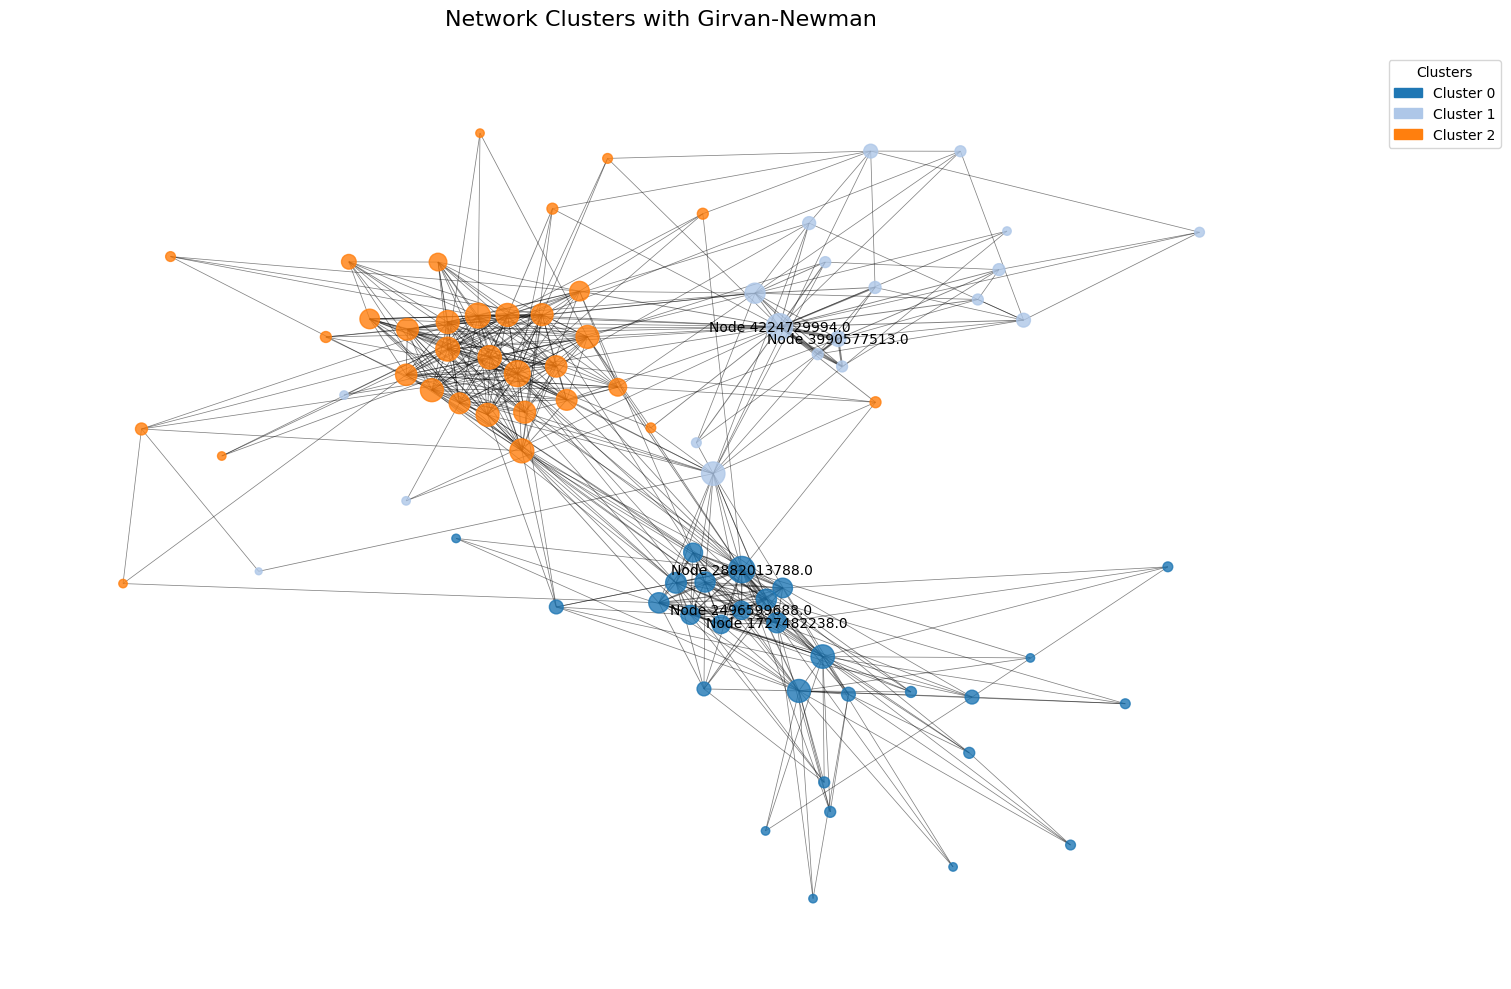

In [123]:
def clean_graph(G, min_degree=2, min_edge_weight=0.1):
    """
    Cleans the graph by removing isolated nodes, weak edges, and self-loops.
    
    Parameters:
        G (nx.Graph): The input NetworkX graph to be cleaned.
        min_degree (int): Minimum degree a node should have to remain in the graph.
        min_edge_weight (float): Minimum weight of an edge to remain in the graph.
        
    Returns:
        nx.Graph: The cleaned graph.
    """
    # Remove isolated nodes (nodes with degree 0)
    G.remove_nodes_from(list(nx.isolates(G)))
    
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    # Remove nodes with degree less than min_degree
    nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree < min_degree]
    G.remove_nodes_from(nodes_to_remove)
    
    # Remove edges with weight less than the minimum threshold (if weighted)
    weak_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('weight', 1) < min_edge_weight]
    G.remove_edges_from(weak_edges)
    
    # Optional: Keep only the largest connected component
    largest_component = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_component).copy()
    
    return G


# Detect clusters using Girvan-Newman
def get_communities_girvan_newman(G, num_clusters=4):
    """
    Applies Girvan-Newman algorithm and returns the top communities.
    
    Parameters:
        G (nx.Graph): Input graph
        num_clusters (int): Number of desired clusters
    
    Returns:
        list: List of sets, where each set is a cluster of nodes
    """
    communities = girvan_newman(G)
    for i, partition in enumerate(communities):
        if i == num_clusters - 2:
            return [set(c) for c in partition]
    return []

# Clean the Graph
cleaned_G = clean_graph(G, min_degree=3, min_edge_weight=0.5)

# Get clusters
clusters = get_communities_girvan_newman(G, num_clusters=3)

# Visualize clusters
visualize_network_clusters(G, clusters, title="Network Clusters with Girvan-Newman")

### Problem 2 

Prepare an infographics/presentation/report containing the most interesting conclusions from the analysis of the results of the previous task.

### Solution 